# News headline topic analysis with Latent Dirichlet allocation (LDA)
The purpose of this analysis is to find dominant topics across news headlines (25 per day, over 1 year). These topics will later be correlated with daily stock market loss/gain information to understand how certain topics influence the stock market.

## What is LDA?
Latent Dirichlet allocation is a way to discover higher-level topics out of individual words present in any set of document (in our case, news headlines). You can use LDA to get a sense of the overall themes in a set of documents. 

LDA is an unsupervised machine learning model that works by analyzing two things: a distribution of topics in a document, and a distribution of words in a topic. The "topics" it finds aren't specific words (e.g., "This headline is about 'war'") but instead conceptually similar groups of words that together make up a theme (e.g., "This headline is similar to the words 'war', 'crisis', 'iran'...").

Once you've created your LDA model, you can feed in a document and the model will score the overall relevancy of your document against the main _x_ topics found in your overall corpus. In other words, it will tell you which of the main topics found in the overall corpus are also found in your document, and to what extent.

## Why LDA?
LDA is a fairly popular topic modelling choice among NLP professionals, and relatively straightforward to implement. Using LDA, we were able to find 10 dominant themes in eight years' worth of news headlines within about an hour—a task that would take a human days to analyze.

## How does text pre-processing affect the accuracy of LDA?
We tested two pre-processing approaches: Bag of Words and TF-IDF, each of which count how often words appear in a document. The TF-IDF model tries to understand which words are more important than others in a document, and scores them accordingly. The assumption was that TF-IDF preprocessing will help train a more accurate LDA model, but that did not turn out to be true; Bag of Words performed better.

## How does LDA perform compared to other topic models?
More here later.

## Credit
Parts of this work borrow from excellent Susan Li's ["Topic Modeling and LDA in Python"](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24) tutorial.

# Load the data from CSV, dependencies

In [43]:
# import dependencies
import pandas as pd

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import numpy as np
import random
np.random.seed(22)

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /Users/stacy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Import the data
data = pd.read_csv("../Data/RedditNews.csv")

In [3]:
data.head()

# 73,608 records from 2016-2018

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [4]:
# Getting just the headlines for our corpus
headlines = data[['News']]
headlines.head()

,News
0,A 117-year-old woman in Mexico City finally re...
1,IMF chief backs Athens as permanent Olympic host
2,"The president of France says if Brexit won, so..."
3,British Man Who Must Give Police 24 Hours' Not...
4,100+ Nobel laureates urge Greenpeace to stop o...


# Data pre-processing
## Lemmitize
In order to properly identify topics, we need to standardize the words in some way, removing extraneous information like tenses or plurals (e.g. "running", "runs" -> "run"). Lemmatization is the best way to do that, although it's not always the fastest way. In some cases, stemming will also work, althought it is not as precise.

Since we have a relatively small corpus to study, we will use lemmatization in order to be as precise as possible when cleaning up the words. To do this, we will feed in a `pos` parameter that tells our lemmatizing function to perform stemming with context.

Natural Language Toolkit's `stem` package includes a handy function called `WordNetLemmatizer` that makes lemmatizing our words simple. 

In [5]:
# Lemmatize the words keeping the context (stemming is "dumb" so we won't)
# However if we have a much larger corpus, we might consider stemming (as it is faster)
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v') # pos='v' means it peforms stemming with context

## Remove stopwords and words shorter than 3 chars
We also need to remove common words that don't add value ("a", "the", etc). These are called _stopwords_, and most NLP libraries have built-in methods for dealing with them. In `gensim`, the stopwords list can be called using `gensim.parsing.preprocessing.STOPWORDS`.

In [6]:
# Remove stopwords and words shorter than 3 characters, then lemmatize
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize(token))
    return result

## Check outputs
Let's compare the regular version of a sample headlind with the tokenized and lemmatized version. You'll note they are slightly different, but retain the same context.

In [7]:
sample = headlines['News'][2]

print('original document: ')
words = []
for word in sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(sample))

original document: 
['The', 'president', 'of', 'France', 'says', 'if', 'Brexit', 'won,', 'so', 'can', 'Donald', 'Trump']


 tokenized and lemmatized document: 
['president', 'france', 'say', 'brexit', 'donald', 'trump']


## Preprocess the headlines and save the results
Now we feed all the headlines into the preprocessing function, which lemmatizes and removes stopwords. 

In [8]:
cleaned_headlines = headlines['News'].map(preprocess)
print(cleaned_headlines[:5]) # Check the results
sample_size = cleaned_headlines.shape[0]

0    [year, woman, mexico, city, finally, receive, ...
1      [chief, back, athens, permanent, olympic, host]
2      [president, france, say, brexit, donald, trump]
3    [british, police, hours, notice, threaten, hun...
4    [nobel, laureates, urge, greenpeace, stop, opp...
Name: News, dtype: object


In [9]:
sample_size

73608

## Count the word occurences using Bag of Words
We can count the words using different approaches. Bag of Words will simply count all remaining words left in our corpus.

In [10]:
# First we need to convert the words to numeric indices. We can do that with a gensim Dictionary.

# corpora.Dictionary implements the concept of a Dictionary – a mapping between words and their integer ids.
# https://radimrehurek.com/gensim/corpora/dictionary.html

dictionary = gensim.corpora.Dictionary(cleaned_headlines)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 alvarez
1 bear
2 birth
3 certificate
4 city
5 die
6 finally
7 hours
8 later
9 lira
10 mexico


In [11]:
'''
Filter out irrelevant words:
Keep tokens that appear in at least 15 documents
Keep only the 100,000 most frequent tokens
'''

dictionary.filter_extremes(no_below=15, keep_n=100000)

In [12]:
'''
Apply `doc2bow` to each headline, which createst a Bag of Words dictionary that reports how many words 
are in the headline and how many times each word appears.

Save this to an array, then check the example headline from above.
'''

bow_corpus = [dictionary.doc2bow(headline) for headline in cleaned_headlines]
print(bow_corpus[2])

bow_doc_2 = bow_corpus[2]

for i in range(len(bow_doc_2)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2[i][0], 
                                            dictionary[bow_doc_2[i][0]], 
                                            bow_doc_2[i][1]))

[(21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]
Word 21 ("brexit") appears 1 time.
Word 22 ("donald") appears 1 time.
Word 23 ("france") appears 1 time.
Word 24 ("president") appears 1 time.
Word 25 ("say") appears 1 time.
Word 26 ("trump") appears 1 time.


## Count the word occurences using TF-IDF
We'll also test whether TF-IDF works better than Bag of Words for creating a corpus that, when fed into our LDA model, will produce coherent and accurate topics. 

In `gensim`, TF-IDF builds on Bag of Words, taking in processed BoW corpus data and returning a number that reflects how important a word is to each headline in the overall corpus. Conversely, the scikit-learn implementation of TF-IDF handles this all in one step.

In [13]:
from gensim import corpora, models

# Create the model
tfidf = models.TfidfModel(bow_corpus)

# Feed in the BoW corpus to the TF-IDF model
corpus_tfidf = tfidf[bow_corpus]

# Print the same headline from above
corpus_tfidf[2]

[(21, 0.5271930944921088),
 (22, 0.5289685708527566),
 (23, 0.3076906708092066),
 (24, 0.25211992539378436),
 (25, 0.18133987533447585),
 (26, 0.5011362450471095)]

## Running LDA using Bag of Words
We'll first run `LdaMulticore` using our `bow_corpus` and limiting our number of topics to 10. We're also going to print out the resulting topics and how the dominant words score in each topic. The parameter `id2word` helps us pass the numeric indices in our dictionary back into human-readable words.

In [14]:
# We'll first split the dataset into a random sample containing 90% of documents.

bow_sample = random.sample(bow_corpus, int(sample_size*.9))

# We have to play around with how many passes to take over the corpus in order to make the topics coherent
lda_model_bow = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2)

In [15]:
# Print each topic and how the words in those topics score (their relative weight)
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.031*"israel" + 0.021*"china" + 0.014*"state" + 0.014*"iran" + 0.013*"say" + 0.011*"attack" + 0.008*"israeli" + 0.008*"unite" + 0.008*"world" + 0.007*"right"
Topic: 1 
Words: 0.012*"bank" + 0.010*"government" + 0.010*"court" + 0.008*"million" + 0.007*"china" + 0.007*"say" + 0.006*"police" + 0.006*"world" + 0.006*"protest" + 0.006*"billion"
Topic: 2 
Words: 0.030*"kill" + 0.019*"attack" + 0.014*"force" + 0.012*"bomb" + 0.009*"soldier" + 0.008*"army" + 0.008*"syria" + 0.008*"state" + 0.008*"syrian" + 0.008*"rebel"
Topic: 3 
Words: 0.023*"north" + 0.022*"kill" + 0.022*"korea" + 0.018*"south" + 0.014*"pakistan" + 0.010*"strike" + 0.009*"say" + 0.008*"death" + 0.008*"children" + 0.008*"people"
Topic: 4 
Words: 0.025*"gaza" + 0.025*"israel" + 0.013*"israeli" + 0.011*"palestinian" + 0.010*"ship" + 0.009*"right" + 0.009*"hamas" + 0.009*"west" + 0.008*"georgia" + 0.007*"human"
Topic: 5 
Words: 0.012*"world" + 0.009*"india" + 0.008*"saudi" + 0.007*"power" + 0.007*"plant" + 0.00

## Running LDA using TF-IDF
We'll run the same LDA model on the corpus processed using TF-IDF, to see if the topics generated here are any more meaningful. We'll use the same other parameters in our `LdaMulticore` model, for consistency.

In [16]:
# Get random sample of tf_idf corpus
corpus_tfidf.corpus

tfidf_sample = random.sample(corpus_tfidf.corpus, int(sample_size*.9))

lda_model_tfidf = gensim.models.LdaMulticore(tfidf_sample, num_topics=10, id2word=dictionary, passes=2)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.027*"korea" + 0.026*"north" + 0.021*"nuclear" + 0.019*"russia" + 0.013*"south" + 0.012*"iran" + 0.011*"say" + 0.009*"japan" + 0.009*"korean" + 0.009*"deal"
Topic: 1 Word: 0.010*"wikileaks" + 0.010*"government" + 0.009*"say" + 0.008*"death" + 0.007*"america" + 0.006*"chinese" + 0.005*"china" + 0.005*"reveal" + 0.005*"state" + 0.005*"document"
Topic: 2 Word: 0.023*"china" + 0.015*"world" + 0.010*"water" + 0.008*"billion" + 0.007*"power" + 0.007*"plan" + 0.007*"germany" + 0.007*"say" + 0.007*"million" + 0.006*"people"
Topic: 3 Word: 0.034*"kill" + 0.012*"saudi" + 0.010*"women" + 0.010*"say" + 0.009*"attack" + 0.009*"police" + 0.009*"shoot" + 0.007*"isis" + 0.007*"soldier" + 0.006*"arrest"
Topic: 4 Word: 0.009*"say" + 0.009*"protest" + 0.009*"government" + 0.007*"call" + 0.006*"european" + 0.006*"police" + 0.006*"school" + 0.006*"pope" + 0.006*"church" + 0.006*"party"
Topic: 5 Word: 0.015*"israeli" + 0.010*"year" + 0.010*"gaza" + 0.009*"jail" + 0.009*"say" + 0.009*"years" 

## Compare the performance of the two preprocessing steps in the LDA model

In [17]:
# our test headline from above
cleaned_headlines[2] # human-readable version of bow_corpus[2]

['president', 'france', 'say', 'brexit', 'donald', 'trump']

### Bag of Words LDA model scores

In [18]:
for index, score in sorted(lda_model_bow[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_bow.print_topic(index, 10)))


Score: 0.8713557124137878	 
Topic: 0.010*"say" + 0.008*"government" + 0.008*"election" + 0.008*"vote" + 0.007*"drug" + 0.007*"country" + 0.006*"party" + 0.006*"people" + 0.006*"european" + 0.006*"president"

Score: 0.01429810468107462	 
Topic: 0.010*"government" + 0.008*"internet" + 0.008*"israeli" + 0.007*"muslim" + 0.006*"say" + 0.006*"protest" + 0.006*"people" + 0.006*"house" + 0.005*"president" + 0.005*"right"

Score: 0.014295266941189766	 
Topic: 0.023*"police" + 0.010*"president" + 0.009*"russian" + 0.009*"year" + 0.008*"woman" + 0.007*"shoot" + 0.007*"protest" + 0.006*"tell" + 0.006*"bush" + 0.006*"arrest"

Score: 0.01429402083158493	 
Topic: 0.025*"iran" + 0.016*"iraq" + 0.016*"russia" + 0.013*"nuclear" + 0.012*"world" + 0.008*"china" + 0.008*"say" + 0.007*"troop" + 0.006*"obama" + 0.005*"military"

Score: 0.014293545857071877	 
Topic: 0.030*"kill" + 0.019*"attack" + 0.014*"force" + 0.012*"bomb" + 0.009*"soldier" + 0.008*"army" + 0.008*"syria" + 0.008*"state" + 0.008*"syrian" 

### TF-IDF LDA model scores

In [19]:
for index, score in sorted(lda_model_tfidf[bow_corpus[2]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index)))


Score: 0.6479489207267761	 
Topic: 0.011*"right" + 0.011*"say" + 0.010*"human" + 0.008*"force" + 0.008*"syria" + 0.006*"internet" + 0.006*"russian" + 0.006*"minister" + 0.006*"david" + 0.005*"rule"

Score: 0.23771002888679504	 
Topic: 0.034*"israel" + 0.017*"president" + 0.011*"israeli" + 0.008*"gaza" + 0.007*"minister" + 0.007*"call" + 0.007*"say" + 0.007*"obama" + 0.006*"peace" + 0.006*"palestinian"

Score: 0.014294163323938847	 
Topic: 0.027*"korea" + 0.026*"north" + 0.021*"nuclear" + 0.019*"russia" + 0.013*"south" + 0.012*"iran" + 0.011*"say" + 0.009*"japan" + 0.009*"korean" + 0.009*"deal"

Score: 0.014293938875198364	 
Topic: 0.024*"police" + 0.012*"protest" + 0.010*"attack" + 0.009*"president" + 0.008*"muslim" + 0.007*"say" + 0.007*"protesters" + 0.007*"anti" + 0.006*"country" + 0.006*"people"

Score: 0.014293520711362362	 
Topic: 0.010*"wikileaks" + 0.010*"government" + 0.009*"say" + 0.008*"death" + 0.007*"america" + 0.006*"chinese" + 0.005*"china" + 0.005*"reveal" + 0.005*"sta

Both approaches have relatively high accuracy with classification (> .80), and mostly make sense when reviewed by a human. What if we predicted topics for a headline that does not appear in our training set?

### Testing models on a new headline
When using an unseen headline, the Bag of Words-trained LDA model appears to classify the headline's topic more accurately.

* Bag of Words top topic: `Topic: 0.023*"iran" + 0.015*"russia" + 0.015*"iraq" + 0.014*"world" + 0.012*"nuclear"`
* TF-IDF top topic: `Topic: 0.012*"say" + 0.011*"government" + 0.007*"call" + 0.007*"pope" + 0.006*"party"`

In [20]:
unseen_document = 'Trump finally broke with Fauci'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("BoW approach\n")
for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_bow.print_topic(index, 5)))
    
print("\nTF-IDF approach")
for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

BoW approach

Score: 0.44918888807296753	 Topic: 0.010*"government" + 0.008*"internet" + 0.008*"israeli" + 0.007*"muslim" + 0.006*"say"
Score: 0.3506779074668884	 Topic: 0.010*"say" + 0.008*"government" + 0.008*"election" + 0.008*"vote" + 0.007*"drug"
Score: 0.025021908804774284	 Topic: 0.023*"police" + 0.010*"president" + 0.009*"russian" + 0.009*"year" + 0.008*"woman"
Score: 0.025019986554980278	 Topic: 0.025*"iran" + 0.016*"iraq" + 0.016*"russia" + 0.013*"nuclear" + 0.012*"world"
Score: 0.025019537657499313	 Topic: 0.012*"bank" + 0.010*"government" + 0.010*"court" + 0.008*"million" + 0.007*"china"
Score: 0.025017429143190384	 Topic: 0.031*"israel" + 0.021*"china" + 0.014*"state" + 0.014*"iran" + 0.013*"say"
Score: 0.02501511387526989	 Topic: 0.025*"gaza" + 0.025*"israel" + 0.013*"israeli" + 0.011*"palestinian" + 0.010*"ship"
Score: 0.02501477487385273	 Topic: 0.030*"kill" + 0.019*"attack" + 0.014*"force" + 0.012*"bomb" + 0.009*"soldier"
Score: 0.025013072416186333	 Topic: 0.023*"nort

## Export the model
We'll use the LDA-Bag of words model, which appears to be more accurate (based on our test documents).

In [21]:
import joblib
joblib.dump(lda_model_bow, "lda_bow.gz")

['lda_bow.gz']

## Append topics and scores to cleaned dataset

In [22]:
# This function returns the best-scoring topic and score assocated with a headline
def topic_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return topic

topic_getter(unseen_document)

8

In [23]:
# Load dataset with combined data
all_data = pd.read_csv('../Data/Combined_News_DJIA.csv')
all_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [24]:
all_data.dropna(how='any', inplace=True)

In [25]:
# Loop through the columns containing headlines and apply `topic_getter` to each headline, to retrieve topic
# Assign that data to a new column

for x in range(1,26): # for each column
    col = "Top" + str(x)
    new_col = col + "_topic"
    
    # for each row in column
    # get the headline, feed it into the lda_model_bow to get the topic and score
    all_data[new_col] = all_data[col].apply(topic_getter)

In [26]:
# Check the output
all_data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16_topic,Top17_topic,Top18_topic,Top19_topic,Top20_topic,Top21_topic,Top22_topic,Top23_topic,Top24_topic,Top25_topic
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,4,2,0,7,2,7,4,2,9,9
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,0,6,6,7,9,2,6,4,7,5
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,4,9,4,7,1,4,6,9,9,5
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,3,7,4,4,7,0,7,4,4,6
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,0,0,4,4,6,8,7,4,2,2


In [27]:
# Save updated data
all_data.to_csv("../Data/Combined_News_DJIA_topics.csv")

In [75]:
# TODO add chart showing overall topic distribution counts

# Find one dominant topic per day

In [28]:
single_topic = all_data
del all_data # Removing now that unneeded to improve performance

In [29]:
# Drop unnecessary columns from prev dataframe
cols = []
for x in range(1,26):
    cols.append("Top" + str(x) + "_topic")  

single_topic.drop(axis=1, labels=cols, inplace=True)
single_topic.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [30]:
# Combine, clean single_topic headlines 
single_topic.loc[:,'combined_headlines'] = single_topic.loc[:,'Top1'] + " " + single_topic.loc[:,'Top2'] \
                                        + " " + single_topic.loc[:,'Top3'] + " " + single_topic.loc[:,'Top4'] \
                                        + " " + single_topic.loc[:,'Top5'] + " " + single_topic.loc[:,'Top6'] \
                                        + " " + single_topic.loc[:,'Top7'] + " " + single_topic.loc[:,'Top8'] \
                                        + " " + single_topic.loc[:,'Top9'] + " " + single_topic.loc[:,'Top10'] \
                                        + " " + single_topic.loc[:,'Top11'] + " " + single_topic.loc[:,'Top12'] \
                                        + " " + single_topic.loc[:,'Top13'] + " " + single_topic.loc[:,'Top14'] \
                                        + " " + single_topic.loc[:,'Top15'] + " " + single_topic.loc[:,'Top16'] \
                                        + " " + single_topic.loc[:,'Top17'] + " " + single_topic.loc[:,'Top18'] \
                                        + " " + single_topic.loc[:,'Top19'] + " " + single_topic.loc[:,'Top20'] \
                                        + " " + single_topic.loc[:,'Top21'] + " " + single_topic.loc[:,'Top22'] \
                                        + " " + single_topic.loc[:,'Top23'] + " " + single_topic.loc[:,'Top24'] \
                                        + " " + single_topic.loc[:,'Top25']

single_topic.loc[:,'combined_headlines'] = single_topic.loc[:,'combined_headlines'].str.replace('b[\'\"]', ' ')
single_topic.dropna(how='any', inplace=True)

cleaned_all_headlines = single_topic['combined_headlines'].map(preprocess)

single_topic.iloc[905,:]

Date                                                         2012-03-16
Label                                                                 0
Top1                  Chinese official proposes death penalty as det...
Top2                  New Chevron Oil Leak Off Coast of Brazil - Jus...
Top3                    Shell admits to at least 207 oil spills in 2011
Top4                  A Jewish man wins his fight against a German m...
Top5                  UK would not help Israel attack Iran, Prime Mi...
Top6                  "Afghan President Hamid Karzai lashed out at t...
Top7                  Putin's Fabled Tiger Encounter was PR Stunt, S...
Top8                  Moroccans call for end to rape-marriage laws -...
Top9                  Friends no more? Egypts MPs declare Israel No....
Top10                 In emails, the nuclear physicist at one of Eur...
Top11                 Syrian armed forces desertion said to surge to...
Top12                 A Moroccan government minister on Thursday

In [31]:
# Count word occurences using Bag of Words on new cleaned_headlines
dictionary = gensim.corpora.Dictionary(cleaned_all_headlines)

In [32]:
'''
Filter out irrelevant words:
Keep tokens that appear in at least 15 documents
Keep only the 100,000 most frequent tokens
'''

dictionary.filter_extremes(no_below=15, keep_n=100000)

In [33]:
'''
Apply `doc2bow` to each headline, which createst a Bag of Words dictionary that reports how many words 
are in the headline and how many times each word appears.

Save this to an array, then check the example headline from above.
'''


bow_corpus = [dictionary.doc2bow(headline) for headline in cleaned_all_headlines]
print(bow_corpus[2])

bow_doc_2 = bow_corpus[2]

for i in range(len(bow_doc_2)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2[i][0], 
                                            dictionary[bow_doc_2[i][0]], 
                                            bow_doc_2[i][1]))

[(12, 1), (13, 1), (15, 1), (21, 1), (30, 1), (33, 10), (34, 4), (42, 1), (44, 1), (45, 1), (47, 1), (58, 1), (59, 3), (62, 2), (63, 1), (65, 1), (66, 1), (67, 2), (68, 3), (78, 1), (83, 5), (84, 2), (94, 4), (95, 1), (103, 2), (106, 1), (111, 1), (121, 1), (125, 1), (136, 1), (139, 2), (199, 1), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 1), (208, 1), (209, 1), (210, 1), (211, 1), (212, 1), (213, 1), (214, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 1), (221, 1), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 2), (230, 2), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 1), (238, 1), (239, 2), (240, 1), (241, 1), (242, 1), (243, 1), (244, 1), (245, 1), (246, 1), (247, 1), (248, 1), (249, 1), (250, 1), (251, 1), (252, 1), (253, 1), (254, 1), (255, 2), (256, 1), (257, 2), (258, 1), (259, 1), (260, 1), (261, 1), (262, 1), (263, 1), (264, 1), (265, 1), (266, 1), (267, 1), (268, 1), (269, 1), (2

In [34]:
# Run new BoW data through LDA model

'''
NOTE: Run this on a machine with lots of processing power, or as a Google Colab notebook. Otherwise it might
take a really long time to run! TODO: Refactor this notebook to optimize performance so it can be run locally.
'''

bow_sample = random.sample(bow_corpus, int(cleaned_all_headlines.shape[0]*.9))

lda_model_bow = gensim.models.LdaMulticore(bow_sample, num_topics=10, id2word=dictionary, passes=2)

In [35]:
# Print each topic and how the words in those topics score (their relative weight)
for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"north" + 0.003*"protest" + 0.003*"isis" + 0.003*"syria" + 0.003*"country" + 0.003*"minister" + 0.003*"plan"
Topic: 1 
Words: 0.006*"russian" + 0.006*"russia" + 0.004*"force" + 0.004*"president" + 0.004*"military" + 0.004*"million" + 0.004*"syria" + 0.003*"protest" + 0.003*"group" + 0.003*"warn"
Topic: 2 
Words: 0.007*"russia" + 0.004*"japan" + 0.003*"korea" + 0.003*"president" + 0.003*"country" + 0.003*"force" + 0.003*"power" + 0.003*"call" + 0.003*"time" + 0.003*"military"
Topic: 3 
Words: 0.006*"russia" + 0.004*"iran" + 0.004*"force" + 0.004*"military" + 0.004*"ukraine" + 0.004*"north" + 0.004*"right" + 0.004*"south" + 0.004*"korea" + 0.003*"russian"
Topic: 4 
Words: 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"
Topic: 5 
Words: 0.005*"russian" + 0.005*"russia" + 0.005*"force" + 0.004*"i

In [36]:
# Test new model on unseen dataset
unseen_document = 'Trump finally broke with Fauci'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

print("BoW approach\n")
for index, score in sorted(lda_model_bow[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model_bow.print_topic(index, 10)))
    
# This has a higher accuracy score than the per-headline topic analysis above

BoW approach

Score: 0.7748336791992188	 Topic: 0.008*"israeli" + 0.007*"gaza" + 0.005*"right" + 0.004*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"country" + 0.003*"arrest" + 0.003*"children" + 0.003*"president"
Score: 0.02502548322081566	 Topic: 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"north" + 0.003*"protest" + 0.003*"isis" + 0.003*"syria" + 0.003*"country" + 0.003*"minister" + 0.003*"plan"
Score: 0.025019029155373573	 Topic: 0.005*"russia" + 0.004*"bank" + 0.004*"force" + 0.004*"president" + 0.004*"time" + 0.003*"death" + 0.003*"military" + 0.003*"right" + 0.003*"snowden" + 0.003*"plan"
Score: 0.025018997490406036	 Topic: 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"
Score: 0.025018172338604927	 Topic: 0.005*"iran" + 0.005*"israeli" + 0.005*"gaza" + 0.004*"russia" + 0.004*"minister" + 0.004*"nuclear" + 0.004*"right" + 0.003*"want" + 0.003*"c

In [37]:
# This function returns the best-scoring topic and score assocated with a headline
def topic_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return topic
    
def word_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        return lda_model_bow.print_topic(topic, 10)    

# Test to confirm it still returns the topic for a particular headline
topic_getter(unseen_document)
word_getter(unseen_document)

'0.008*"israeli" + 0.007*"gaza" + 0.005*"right" + 0.004*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"country" + 0.003*"arrest" + 0.003*"children" + 0.003*"president"'

In [38]:
# Create a combined function to test our testing dataset against    

population = 1986

def test_getter(headline):
    if headline == np.nan:
        return np.nan
    else:
        processed_headline = dictionary.doc2bow(preprocess(headline))
        topic_scores = sorted(lda_model_bow[processed_headline], key=lambda tup: -1*tup[1])
        topic = int(topic_scores[0][0])
        # Print a headline snippet and the topic so we can visually compare each headline set against the assigned topic
        print(f"headline: {headline[0:300]}\n\n topic: {str(topic)} {lda_model_bow.print_topic(topic, 10)}\n\n")    

# Create a random sample of 20% of our overall document set        
sample_series = random.sample(list(single_topic['combined_headlines']), int(population*.2))

for headline in sample_series:
    test_getter(headline)

headline: US, Canada, New Zealand, Sweden, and others at UN condemn "three strikes" Internet laws, say the laws violate human rights Canada to legalize prostitution? Ontario court case could make prostitution and brothels legal.  A 300-acre luxury hotel, villa, golf course, &amp; an airport funded by British 

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline:  Breaking news: All serious crimes in the UK have been solved.'  Absolutely heartbreaking. These kids in villages across Nigeria are beaten, tortured, burned, starved, and murdered because some idiot religious figure deemed them witches '  Awareness Of Outside World Growing In North Korea'  Irish to

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: 

headline: Mexican missing student activist who led search parties after the disappearance of 43 students is killed. China, Russia and the U.S. are developing and testing controversial new capabilities to wage war in space despite their denial of such work Zimbabwe lifts ban on lion hunts South Korea on Monday

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"north" + 0.003*"protest" + 0.003*"isis" + 0.003*"syria" + 0.003*"country" + 0.003*"minister" + 0.003*"plan"


headline: Canada tries to cut cost of US drug, gets sued Elon Musk Says Climate Change Refugees Will Dwarf Current Crisis. Tesla's CEO says the Volkswagen scandal is minor compared with carbon dioxide emissions. British doctors hail 'cure for blindness' with successful treatment of age-related macular degener

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"north" + 0.003*"protest" + 0.003*"isis" + 0.003*"syria" + 0.003*"country" + 0.003*"minister" + 0.003*"plan"


headline: Solar Powe

headline: Liberia to become 1st nation in Africa to completely stop cutting down its trees in return for development aid - Norway will pay the impoverished country $150m to stop deforestation by 2020. US Airstrikes Under Way in Syria Google will stop supporting climate change science deniers, calls them liars

 topic: 9 0.005*"russia" + 0.004*"bank" + 0.004*"force" + 0.004*"president" + 0.004*"time" + 0.003*"death" + 0.003*"military" + 0.003*"right" + 0.003*"snowden" + 0.003*"plan"


headline: British Columbia has a strong appetite for marijuana reform with more than 70% of respondents to a new poll urging either legalization or decriminalization. The Insights West survey found 67% said they support outright legalization, 28% opposed it and 5% were undecided. Japan: Elderly overtake teena

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Fuel h

headline: Hungary internet tax cancelled after mass protests Indian government bars first class travel, five-star hotel meetings for bureaucrats and have been asked to use video-conferencing instead to reduce expenditure on them For 3 days starting in 1 week, 8,000 glowing balloons are being installed across 

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"north" + 0.003*"protest" + 0.003*"isis" + 0.003*"syria" + 0.003*"country" + 0.003*"minister" + 0.003*"plan"


headline: AirAsia flight found at the bottom of the Java Sea North Korean defector details 'human experiments' -- use of mentally and physically handicapped children in chemical weapons tests 'the last straw' Korean Air ex-executive Cho Hyun-ah arrested - earlier she ordered a plane to turn back on the runway

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Julia

headline:  Professional snipers have been brought in to guard a vulnerable colony of penguins in Australia.'  Natalia Estemirova, a lifelong human rights campaigner, was kidnapped from her home yesterday morning.  Today she was found dead, left on a road with bullet wounds to the head and chest.'  DOJ Pressur

 topic: 3 0.006*"russia" + 0.004*"iran" + 0.004*"force" + 0.004*"military" + 0.004*"ukraine" + 0.004*"north" + 0.004*"right" + 0.004*"south" + 0.004*"korea" + 0.003*"russian"


headline: Cairo residents in Egypt remove passwords from their wi-fi routers so protesters can communicate with the world An Egyptian protester faces a water canon vehicle solo.  Mahmoud Saad, a talk show host in the Egyptian state-run TV, has announced that he will no longer appear on TV starting tonight aft

 topic: 6 0.005*"iran" + 0.005*"israeli" + 0.005*"gaza" + 0.004*"russia" + 0.004*"minister" + 0.004*"nuclear" + 0.004*"right" + 0.003*"want" + 0.003*"call" + 0.003*"plan"


headline: 'What's it like 

headline: Norwegian Air CEO Says $69 Flights From U.S. to Europe Coming Soon 4 Russian warships launch 26 missiles against ISIS from Caspian sea Wind power is now the cheapest electricity to produce in both Germany and the U.K., even without government subsidies. Paedophile bishop escaped charges after MPs an

 topic: 8 0.007*"north" + 0.005*"korea" + 0.004*"right" + 0.004*"death" + 0.003*"court" + 0.003*"time" + 0.003*"nuclear" + 0.003*"iran" + 0.003*"germany" + 0.003*"south"


headline: World Cup sponsors urged to bail over 'horrific' treatment of workers in Qatar ThePirateBay.se and PirateBay.se have been seized A US appeals court has ruled that YouTube should be allowed to show the uploaded film 'Innocence of Muslims' that sparked outrage in the Arab world in 2012. Child abuser s

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Beijing now

headline: Wikileaks. Brazil's President Lula defends Assange: "Instead of blaming someone who has disclosed these documents, those who wrote them should be blamed" Wikileaks Reveals U.S. Tax Dollars Fund Child Sex Slavery in Afghanistan "They're entitled to be paid it, [and] we're entitled to tax it" - Irelan

 topic: 7 0.008*"israeli" + 0.007*"gaza" + 0.005*"right" + 0.004*"iran" + 0.004*"time" + 0.004*"news" + 0.004*"country" + 0.003*"arrest" + 0.003*"children" + 0.003*"president"


headline: UN declares clean water a 'fundamental human right' Leaked documents from the Afghanistan war appear to confirm that Australian forces are backing a local war lord who has been extorting money from NATO convoys carrying supplies to Coalition forces. Anti-US Protestors Arrested At Base In Sweden - "T

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"north" + 0.003*"protest" + 0.003*"isis" + 0.003*"syria" + 0.003*"country" + 0.003*"minister" + 0.003*"plan"


headline: German gov

headline: British computer hacker Gary McKinnon will not be extradited to the US For eight months, starting last November, he was the prime minister of his native country, Somalia, one of the most chaotic nations on earth. And then, as suddenly as he had left, he was back in his cubicle at the Transportation 

 topic: 0 0.004*"president" + 0.003*"time" + 0.003*"force" + 0.003*"north" + 0.003*"protest" + 0.003*"isis" + 0.003*"syria" + 0.003*"country" + 0.003*"minister" + 0.003*"plan"


headline: In world's 1st commercial deep-sea mining project, Canadian firm will mine for gold &amp; copper in Papua New Guinea's seabed,  despite vehement objections over threat to marine life -  Nautilus Minerals has been granted a 20-yr license 

 "Honour killing" evolves: Punjab girl hires contract killers

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: Austr

headline: Fifa president Sepp Blatter and Uefa boss Michel Platini have been suspended for eight years from all football-related activities following an ethics investigation. A group of Kenyan Muslims travelling on a bus ambushed by Islamist gunmen protected Christian passengers by refusing to be split into g

 topic: 1 0.006*"russian" + 0.006*"russia" + 0.004*"force" + 0.004*"president" + 0.004*"military" + 0.004*"million" + 0.004*"syria" + 0.003*"protest" + 0.003*"group" + 0.003*"warn"


headline: Ireland to legalise abortion Berlin warns Egypt is sliding to dictatorship Chinese Authorities Arrest Dozens For Spreading Mayan Apocalypse Rumors Swedish teens riot over Instagram sex rumours  - "500 people are estimated to have gathered outside the 'Plus Gymnasium', according to Aftonbladet" (Link

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: 

headline: Maldives girl gets 100 lashes for pre-marital sex. 'A 15-year-old rape victim has been sentenced to 100 lashes for engaging in premarital sex, court officials said' Compulsive liar jailed after 11 false rape claims in decade Australian Muslim activists lose free speech case. 'Australia's highest cou

 topic: 4 0.004*"country" + 0.004*"russia" + 0.004*"right" + 0.004*"president" + 0.004*"protest" + 0.003*"israeli" + 0.003*"force" + 0.003*"korea" + 0.003*"chinese" + 0.003*"court"


headline: F1 chief Bernie Ecclestone says Bahrain Grand Prix will be cancelled after 11 F1 teams objected Germany has been doing well economically: carrot &amp; stick social programs have pushed people back to work; average real wages up 30% since 1985; tougher down payment rules on houses prevented a bubble;

 topic: 9 0.005*"russia" + 0.004*"bank" + 0.004*"force" + 0.004*"president" + 0.004*"time" + 0.003*"death" + 0.003*"military" + 0.003*"right" + 0.003*"snowden" + 0.003*"plan"


headline:  Pirat

This seems to work all right, but we should eventually explore options for understanding the "coherence" of each topic (here's an example of what coherence looks like with [an NMF model](https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb)). The topics aren't perfect, thus we may want to find a more optimal number of topics to split our texts into.

Given the small population of combined headline texts (~1900), we should also eventually explore [k-fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/), which is often better than setting train-test splits for smaller populations.

In [39]:
single_topic['daily_topic'] = single_topic['combined_headlines'].apply(topic_getter)
single_topic['daily_words'] = single_topic['combined_headlines'].apply(word_getter)

In [40]:
single_topic.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top19,Top20,Top21,Top22,Top23,Top24,Top25,combined_headlines,daily_topic,daily_words
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",Georgia 'downs two Russian warplanes' as coun...,1,"0.006*""russian"" + 0.006*""russia"" + 0.004*""forc..."
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",Why wont America and Nato help us? If they wo...,1,"0.006*""russian"" + 0.006*""russia"" + 0.004*""forc..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,"b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",Remember that adorable 9-year-old who sang at...,1,"0.006*""russian"" + 0.006*""russia"" + 0.004*""forc..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,"b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,U.S. refuses Israel weapons to attack Iran: ...,1,"0.006*""russian"" + 0.006*""russia"" + 0.004*""forc..."
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,"b'""Non-media"" photos

In [41]:
# Save updated data
single_topic.to_csv("../Data/Combined_News_DJIA_single_topic.csv", index=False)

Text(0.5, 1.0, 'Topic distribution')

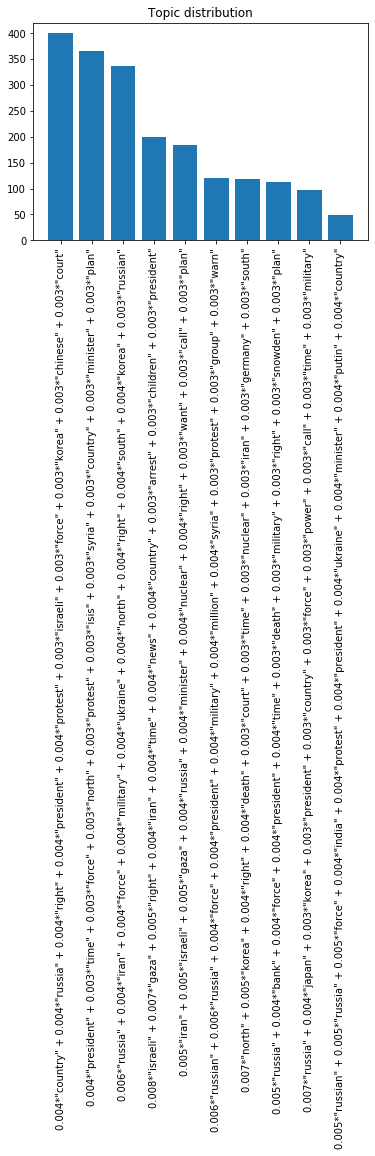

In [74]:
# What is the topic distribution?

names = single_topic['daily_words'].value_counts().index
values = single_topic['daily_words'].value_counts().values
plt.bar(names, values)
plt.xticks(names, rotation=90)
plt.title("Topic distribution")

In [1]:
# Export our improved LDA model